<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/VizdoomSB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install libgtk2.0-dev libsdl2-dev -qq -y >/dev/null || exit 2
!git clone https://github.com/shakenes/vizdoomgym.git
%cd /content/vizdoomgym
!pip install -e . >/dev/null || exit 2
# 5以上かかります

In [ ]:
!pip install wandb > /dev/null
!pip install stable_baselines3 >/dev/null || exit 2

## 註　専用ライブラリが必要です
実行前に*mydoomenvs.py* をアップロードし、ランタイムをリセットして実行してください。（下につけておきますので、mydoomenv.pyという名で保存してください）

アップロードしてあるのにライブラリがないと言われる場合があります。Colabはファイルの読み込み時にタイムラグがあるためだと思われますので、再度ランタイムのリセットを試してください。

専用ライブラリには、２つのシナリオ、 'myVizdoomBasic-v0'
と 'myVizdoomCorridor-v0'だけ入れてあります。

ほかのシナリオが試したければ、Vizdoomの Github から取ってきて追加してください。少し修正が必要ですが、見ればわかるでしょう。


In [ ]:
import gym
import vizdoomgym
import wandb
import mydoomenvs
from mydoomenvs import make_doom_env
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

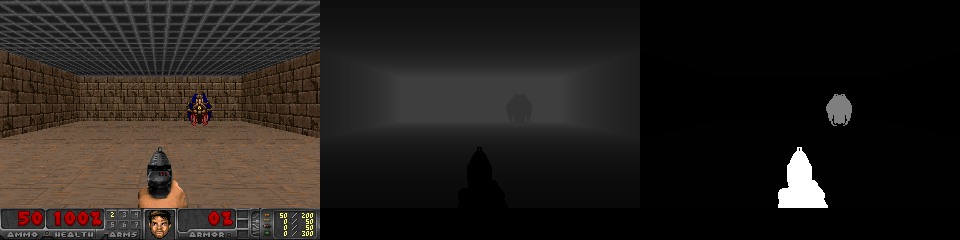

In [ ]:
env = gym.make('myVizdoomBasic-v0', depth=True, labels=True, position=True, health=True)
width = 320
hight = 240
observation = np.zeros((hight,width*3,3),dtype=np.uint8)
state = env.reset()
env.render()
action = env.action_space.sample()
state, reward, done, info = env.step(action)
img = cv2.cvtColor(state[0],cv2.COLOR_RGB2BGR)
depth = cv2.cvtColor(state[1],cv2.COLOR_GRAY2BGR)
label = cv2.cvtColor(state[2],cv2.COLOR_GRAY2BGR)
observation[:,:width,:]=img
observation[:,width:width*2,:]=depth
observation[:,width*2:width*3,:]=label
Image.fromarray(observation)
env.close()

# オプションなし

In [ ]:
env = gym.make('myVizdoomBasic-v0')
env.reset().shape

(240, 320, 3)

オプションなしで環境を作った場合は、通常通り画像のみが返ってくる

In [ ]:
env.action_space,env.get_keys_to_action()

(Discrete(3),
 {(): 2, (97,): 0, (100,): 1, (101,): 6, (113,): 5, (115,): 4, (119,): 3})

アクションが３つしかない。左右とファイア。

なお、環境によってアクション数は異なります。


```
        keys = {
            (): 2,
            (ord("a"),): 0,
            (ord("d"),): 1,
            (ord("w"),): 3,
            (ord("s"),): 4,
            (ord("q"),): 5,
            (ord("e"),): 6,
        }
```
97はA, 100はD　通常、Aは左、Dは右に使われるキーなので、
0が左、１が右、とすれば、２がFIREか


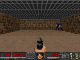

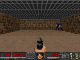

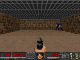

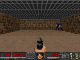

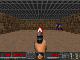

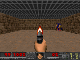

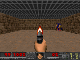

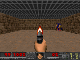

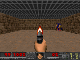

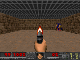

[-1.0, -1.0, -1.0, -1.0, -6.0, -1.0, -1.0, -1.0, -1.0, -1.0] {'dummy': 0.0}


In [ ]:
env.reset()
rw = []
for i in range(10):
  img,r,d,i = env.step(2)
  rw.append(r)
  cv2_imshow(cv2.resize(img[:,:,::-1],(80,60)))
print(rw,info)

*トリガーを引いても、実際に弾が出るタイミングはずれる。*

In [ ]:
env.game.get_state().screen_buffer.shape

(3, 240, 320)

# [シナリオ](https://github.com/shakenes/vizdoomgym/tree/master/vizdoomgym/envs/scenarios)

## Basic 'myVizdoomBasic-v0'

REWARDS:

+101 モンスターを倒す  
 -5 タイムアウト・モンスターを倒したがエピソードが終了してしまった  
時間経過 -1,

ボタン：　0 左　1 右  2 Fire

timeout = 300

## DEADLY CORRIDOR  'myVizdoomCorridor-v0'

REWARDS:

通路の奥にある緑のベストに近づけば＋、遠ざかれば－の報酬。

ボタン：７つ
左を向く、右を向く、前進、後退、左移動、右移動、攻撃

death penalty = 100

doom_skill = 5　（全部で6匹モンスターがいるが、5匹殺さないとベストにたどり着いても死ぬ

timeout = 2100





# PPOによる強化学習の例

In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv,SubprocVecEnv,VecFrameStack,VecEnv
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import wandb,os
import numpy as np
import torch,gym
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(repr(device))

device(type='cuda', index=0)


In [ ]:
# from stable_baselines3.common.env_util import make_atari_env,make_vec_env , make_vec_env #, AtariWrapper
from stable_baselines3.common.vec_env import DummyVecEnv,SubprocVecEnv,VecFrameStack,VecEnv
from mydoomenvs import make_doom_env

env = make_doom_env( 'myVizdoomCorridor-v0', n_envs=4, seed=0,vec_env_cls=DummyVecEnv, monitor_dir= "test")
env = VecFrameStack(env, n_stack=4)

def render(env):
  img = env.unwrapped.game.get_state().screen_buffer
  return np.transpose(img, [1, 2, 0])

from PIL import Image 
Image.fromarray(render(env.envs[0]))


vizdoomenv は通常の環境のように env.render(mode='rgb_array')では画像が返されないので注意

In [ ]:
log_dir ='/content/drive/MyDrive/M/vizdoom'

# Inside my model training code 
!export WANDB_NOTEBOOK_NAME="VIZDOOM.ipynb"
import wandb
PROJECTNAME='VizDoom'
wandb.init(project=PROJECTNAME)

wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/sdk/wandb_run.py", line 1286, in _atexit_cleanup
    self._on_finish()
  File "/usr/local/lib/python3.6/dist-packages/wandb/sdk/wandb_run.py", line 1437, in _on_finish
    self._backend.interface.publish_telemetry(self._telemetry_obj)
  File "/usr/local/lib/python3.6/dist-packages/wandb/sdk/interface/interface.py", line 182, in publish_telemetry
    self._publish(rec)
  File "/usr/local/lib/python3.6/dist-packages/wandb/sdk/interface/interface.py", line 455, in _publish
    raise Exception("The wandb backend process has shutdown")
Exception: The wandb backend process has shutdown


In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
from mydoomenvs import recordModelCallback
log_dir = "test"

def ev(lr):
    monargs={'usewandb':True}
    env = make_doom_env('myVizdoomCorridor-v0', n_envs=8, seed=0,vec_env_cls=DummyVecEnv, monitor_dir=log_dir)
    env = VecFrameStack(env, n_stack=8)   

    model = PPO('CnnPolicy', env, verbose=0,device=device,        
        learning_rate = lr,  # default  3e-4
        gamma = 0.99,
        n_steps = 2048, # 2048
        clip_range = 0.2, # default 0.2
        ent_coef = 0.01, # default 0.01
        batch_size = 128, # 64
        n_epochs = 8 ) # 4

    # model.load('/content/drive/MyDrive/M/smb/best_model.zip')
    callback = recordModelCallback(check_freq=50, log_dir=log_dir, usewandb=True)
    total_timesteps = 1e7
    %time model.learn(total_timesteps=total_timesteps,callback=callback)

学習実行

In [ ]:
ev(2.5e-4)

<img width="441" alt="v" src="https://user-images.githubusercontent.com/5820803/104343711-9ff70a00-553f-11eb-98fe-9cc077ffb97f.png">


# 動画化

In [ ]:

env = make_doom_env('myVizdoomCorridor-v0', n_envs=1, seed=0,vec_env_cls=DummyVecEnv)
env = VecFrameStack(env, n_stack=8) 
model = PPO('CnnPolicy',env)
model = PPO.load('test/vdcorridorbest.zip')

def render(env):
  img = env.unwrapped.game.get_state().screen_buffer
  return np.transpose(img, [1, 2, 0])

width,height = 320,240
while True:
  images = []
  obs = env.reset()
  img = render(env.envs[0])
  if isinstance(img,np.ndarray):
      images.append(img)
  complete = False
  wr = 0
  while not complete:
    action, _ = model.predict(obs)
    obs, r, done ,info = env.step(action)
    wr += r[0]
    img = render(env.envs[0])
    if isinstance(img,np.ndarray):
        images.append(img)
    if done[0]:
      if wr > 300:
          print(len(images),wr)
          complete = True
      break
  if complete:
      break

# mp4動画化

In [ ]:
frame_rate = 30.0  #FPS
def timelaps(images,width,height):
    fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
    video = cv2.VideoWriter('demo2.mp4', fourcc, frame_rate, (width, height))
    for img in images:
        video.write(img) 
    video.release()
timelaps(images,width=width,height=height)

**mydoomenvs.py**

```

from stable_baselines3.common.env_util import make_atari_env,make_vec_env , make_vec_env #, AtariWrapper
from stable_baselines3.common.atari_wrappers import MaxAndSkipEnv #NoopResetEnv,EpisodicLifeEnv,
from stable_baselines3.common.atari_wrappers import FireResetEnv,ClipRewardEnv # WarpFrame,
from stable_baselines3.common.type_aliases import GymObs, GymStepReturn
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv,SubprocVecEnv,VecFrameStack,VecEnv
from typing import List,Optional,Tuple,Union,Any, Callable, Dict,Type, Union
#import gym_super_mario_bros
from gym import spaces
#from nes_py.wrappers import JoypadSpace
import numpy as np,gym
import os, cv2
import wandb
#from gym_super_mario_bros.actions import SIMPLE_MOVEMENT,COMPLEX_MOVEMENT,RIGHT_ONLY

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env: gym.Env, width: int = 84, height: int = 84):
        gym.ObservationWrapper.__init__(self, env)
        self.width = width
        self.height = height
        self.observation_space = spaces.Box(
            low=0, high=255, shape=(self.height, self.width, 1), dtype=env.observation_space.dtype
        )
    def observation(self, frame: np.ndarray) -> np.ndarray:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None] 
  
class SMBWrapper(gym.Wrapper):
    def __init__(
        self,
        env: gym.Env,
        #noop_max: int = 30,
        frame_skip: int = 4,
        screen_sizeH: int = 90,
        screen_sizeW: int = 120, 
        clip_reward: bool = False,
    ):
        #env = NoopResetEnv(env, noop_max=noop_max)
        env = MaxAndSkipEnv(env, skip=frame_skip)
        env = WarpFrame(env, width=screen_sizeW, height=screen_sizeH)
        if clip_reward:
            env = ClipRewardEnv(env)

        super().__init__(env)

def make_doom_env(
    env_id: Union[str, Type[gym.Env]],
    n_envs: int = 1,
    seed: Optional[int] = None,
    start_index: int = 0,
    monitor_dir: Optional[str] = None,
    wrapper_kwargs: Optional[Dict[str, Any]] = None,
    env_kwargs: Optional[Dict[str, Any]] = None,
    vec_env_cls: Optional[Union[DummyVecEnv, SubprocVecEnv]] = None,
    vec_env_kwargs: Optional[Dict[str, Any]] = None,
) -> VecEnv:

    if wrapper_kwargs is None:
        wrapper_kwargs = {}

    def doom_wrapper(env: gym.Env) -> gym.Env:
        env = SMBWrapper(env, **wrapper_kwargs)
        return env

    return SMBmake_vec_env(
        env_id,
        n_envs=n_envs,
        seed=seed,
        start_index=start_index,
        monitor_dir=monitor_dir,
        wrapper_class=doom_wrapper,
        env_kwargs=env_kwargs,
        vec_env_cls=vec_env_cls,
        vec_env_kwargs=vec_env_kwargs,
    )

def SMBmake_vec_env(
    env_id: Union[str, Type[gym.Env]],
    n_envs: int = 1,
    seed: Optional[int] = None,
    start_index: int = 0,
    monitor_dir: Optional[str] = None,
    wrapper_class: Optional[Callable[[gym.Env], gym.Env]] = None,
    env_kwargs: Optional[Dict[str, Any]] = None,
    vec_env_cls: Optional[Type[Union[DummyVecEnv, SubprocVecEnv]]] = None,
    vec_env_kwargs: Optional[Dict[str, Any]] = None,
) -> VecEnv:

    env_kwargs = {} if env_kwargs is None else env_kwargs
    vec_env_kwargs = {} if vec_env_kwargs is None else vec_env_kwargs

    def make_env(rank):
        def _init():
            if isinstance(env_id, str):
                env = gym.make(env_id, **env_kwargs)
            else:
                env = env_id(**env_kwargs)
            if seed is not None:
                env.seed(seed + rank)
                env.action_space.seed(seed + rank)
            monitor_path = os.path.join(monitor_dir, str(rank)) if monitor_dir is not None else None
            if monitor_path is not None:
                os.makedirs(monitor_dir, exist_ok=True)
            env = Monitor(env, filename=monitor_path)
            if wrapper_class is not None:
                env = wrapper_class(env)
            return env

        return _init

    # No custom VecEnv is passed
    if vec_env_cls is None:
        # Default: use a DummyVecEnv
        vec_env_cls = DummyVecEnv

    return vec_env_cls([make_env(i + start_index) for i in range(n_envs)], **vec_env_kwargs)

## 最適モデルの保存用のコールバック関数
# make_atari_env() は内部でベクトル化前の環境をMonit()でラップして csv 形式のログを記録しているので、そこから直近の報酬データを取り出し、
# 平均報酬最大尾も# 最適モデルの保存用のコールバック関数

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy

class recordModelCallback(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose=1, usewandb=False):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf # 直近2*check_freqの平均スコアのベスト
        self.usewandb=usewandb

    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.log_dir, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
          # スコアの検索
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          self.logger.record('timesteps', self.num_timesteps)
          self.logger.record('mean_reward', self.best_mean_reward)
          if self.usewandb:
            wandb.log({'mean_reward':self.best_mean_reward})
            wandb.log({'timesteps':self.num_timesteps})
          if len(x) > 0:
              # 直近100lifeのスコアの平均
              mean_reward = np.mean(y[-2*self.check_freq:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps} : ",end='')
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward/ep: {mean_reward:.2f}")

              # 直近の平均報酬が上昇した場合はモデルを保存
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)
        return True

#################################################
from vizdoomgym.envs.vizdoomenv import VizdoomEnv 
from gym.envs.registration import register

register(
    id='myVizdoomBasic-v0',
    entry_point='mydoomenvs:myVizdoomBasic'
)

register(
    id='myVizdoomCorridor-v0',
    entry_point='mydoomenvs:myVizdoomCorridor'
)

class myVizdoomEnv(VizdoomEnv):
    def step(self, action):
        # convert action to vizdoom action space (one hot)
        act = np.zeros(self.action_space.n)
        act[action] = 1
        act = np.uint8(act)
        act = act.tolist()

        reward = self.game.make_action(act)
        self.state = self.game.get_state()
        done = self.game.is_episode_finished()
        info = {"dummy": 0.0}

        return self.__collect_observations(), reward, done, info

    def __collect_observations(self):
        observation = []
        if self.state is not None:
            observation.append(np.transpose(self.state.screen_buffer, (1, 2, 0)))
            if self.depth:
                observation.append(self.state.depth_buffer)
            if self.labels:
                observation.append(self.state.labels_buffer)
            if self.position:
                observation.append(
                    np.array([self.state.game_variables[i] for i in range(4)])
                )
                if self.health:
                    observation.append(self.state.game_variables[4])
            elif self.health:
                observation.append(self.state.game_variables[0])
        else:
            if type(self.observation_space) == spaces.box.Box:
                space = self.observation_space
                observation.append(np.zeros(space.shape, dtype=space.dtype))
                # there is no state in the terminal step, so a "zero observation is returned instead"
            else:
                for space in self.observation_space:
                    observation.append(np.zeros(space.shape, dtype=space.dtype))   

        # if there is only one observation, return obs as array to sustain compatibility
        if len(observation) == 1:
            observation = observation[0]
        return observation
    def get_action_meanings(self):
        return(["FIRE","LEFT","RIGHT"])

class myVizdoomBasic(myVizdoomEnv):
    def __init__(self, **kwargs):
        super().__init__(0, **kwargs)

class myVizdoomCorridor(myVizdoomEnv):
    def __init__(self, **kwargs):
        super().__init__(1, **kwargs)
```